# Пересборка датафрейма

для модели на 3 входа

## Подключение библиотек, объявление переменных

In [ ]:
import matplotlib.pyplot as plt        # Для прорисовки и визуализации
import os                              # Функции для работы с файлами
import pandas as pd                    # Пандас
import re                              # Работа с регулярными выражениями
import numpy as np
import pickle as pkl
import time
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.saving import load_model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import Precision, Recall, F1Score, FBetaScore
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop, AdamW, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Заполнение последовательностей до определенной длины

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

from google.colab import data_table
data_table.enable_dataframe_formatter()

# Параметры отображения датафреймов
pd.options.display.max_rows     = 99
pd.options.display.max_colwidth = 999

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)


In [ ]:
#!pip install tensorflow-addons
#import tensorflow_addons as tfa
#from tensorflow_addons import metrics

In [ ]:
# Переменные
path_dir = '/content/drive/MyDrive/Media108/'                    # Общий путь для сохранения результатов

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## Процедуры

In [ ]:
def df_to_ohe(df,collist,lst_encoders = {}):
    '''
 Процедура поочередного преобразования колонок из списка через OneHotEncoder в ОНЕ
 С последующей сборкой в единый массив. Параметры:
 df - датафрейм
 collist - список колонок
 Возвращает собранный массив и список энкодеров
    '''
    create_encode = True if len(lst_encoders) == 0 else False
    #print(create_encode)
    list_code = []
    for i in range(len(collist)):
        if create_encode:
            print(f'Формирование OneHotEncoder и кодировка колонки {collist[i]}', end='')
            encoder = OneHotEncoder(handle_unknown='infrequent_if_exist',sparse_output=False)
            encoder.fit(np.array(df[collist[i]].values).reshape(-1, 1))
            lst_encoders[collist[i]] = encoder
            list_code.append(encoder.transform(np.array(df[collist[i]].values).reshape(-1, 1)))
            print(' - Успешно')
        else:
            #print(f'Кодируется колонка {collist[i]}', end='')
            encoder = lst_encoders[collist[i]]
            list_code.append(encoder.transform(np.array(df[collist[i]].values).reshape(-1, 1)))
            #print(' - Успешно')

    x_data = np.hstack(list_code)
    return x_data, lst_encoders

## Загрузка ранее сохраненного датафреема с подгруженными текстами и его дальнейшая обработка.

In [ ]:
df = pd.read_csv(path_dir+'df_target.csv')
#df = df.rename(columns={'Текст_whisper': 'whisper'})
df.shape

(6921, 75)

In [ ]:
# Удалим строки с незаполненной колонкой "Теги"
df_test = df[df['Теги'].isna()]                                    # Выделим незаполненные строки
df_test = df_test.reset_index()                                            # переиндексация датафрйма
del df_test['index']                                                       # Удаление колонки "index" после переиндексации
print(f'Размерность датафрейма до удаления: {df.shape}')
df = df.drop(df[df['Теги'].isna()].index)
df = df.reset_index()                                             # переиндексация датафрйма поле удаления строк
del df['index']                                                       # Удаление колонки "index" после переиндексации
print(f'Размерность датафрейма после удаления: {df.shape}')
print(f'Размерность датафрейма с незаполненной колонкой: {df_test.shape}')

Размерность датафрейма до удаления: (7968, 72)
Размерность датафрейма после удаления: (6921, 72)
Размерность датафрейма с незаполненной колонкой: (1047, 72)


In [ ]:
# Добавление колонки "target" и заполнение ее данными на основе колоки "Теги" 0 - нецелевой, 1 - целевой
df.insert(11,'target',value=np.NaN)
list_teg = df['Теги'].tolist()
list_target = []
for i in range(len(list_teg)):
    list_target.append(1 if (re.search(r'\bПервичный целевой\b',list_teg[i],re.I) != None or re.search(r'\bЦелевой_М108',list_teg[i]) != None) else 0)
    if (re.search(r'\b[Нн]ецелевой\b',list_teg[i],re.I) != None or re.search(r'\b[нН]ецелевой_',list_teg[i]) != None):
        list_target[i] = 0
df['target'] = list_target

In [ ]:
# Добавление колонки "targetall" 1 - любое упоминание целевой 0 - все остальные
df.insert(12,'targetall',value=np.NaN)
list_teg = df['Теги'].tolist()
list_target = []
for i in range(len(list_teg)):
    list_target.append(1 if (re.search(r'\b[Цц]елевой\b',list_teg[i],re.I) != None or re.search(r'\bЦелевой_М108',list_teg[i]) != None) else 0)
df['targetall'] = list_target

In [ ]:
# Создадим колонку "klass" в кторой помести признак по принципу 0 - нецелевой, 1 - спорный (условно целевой), 2- целевой
df.insert(13,'klass',value=df.target + df.targetall)

In [ ]:
df.to_csv(path_dir+'df_target.csv', index=False)
df_test.to_csv(path_dir+'df_no_teg.csv', index=False)

## дообработка

In [ ]:
df = pd.read_csv(path_dir+'df_target.csv')

In [ ]:
# Банасировка по основной целевой колонке
print(df.target.value_counts())
print(f'Соотношение между признаками: {df.target.value_counts()[1]/df.target.value_counts()[0]}')
print(f'Процент минорного клаласа от общего: {round(df.target.value_counts()[1]/len(df)*100,2)}%')

0    4648
1    2273
Name: target, dtype: int64
Соотношение между признаками: 0.4890275387263339
Процент минорного клаласа от общего: 32.84%


In [ ]:
# Банасировка по целевой колонке с разбивкой по компаниям
df.groupby(['Name'])['target'].value_counts()

Name             target
Headliner        0         2714
                 1          550
Павелецкая сити  1          771
                 0          614
Примавера        0         1320
                 1          952
Name: target, dtype: int64

In [ ]:
# Банасировка по дополнительной целевой колонке
print(df.targetall.value_counts())
print(f'Соотношение между признаками: {df.targetall.value_counts()[1]/df.targetall.value_counts()[0]}')
print(f'Процент минорного клаласа от общего: {round(df.targetall.value_counts()[1]/len(df)*100,2)}%')

0    3855
1    3066
Name: targetall, dtype: int64
Соотношение между признаками: 0.7953307392996108
Процент минорного клаласа от общего: 44.3%


In [ ]:
# Банасировка по целевой колонке 'targetall' с разбивкой по компаниям
df.groupby(['Name'])['targetall'].value_counts()

Name             targetall
Headliner        0            1947
                 1            1317
Павелецкая сити  1             780
                 0             605
Примавера        0            1303
                 1             969
Name: targetall, dtype: int64

In [ ]:
# Банасировка по целевой колонке 'klass' с разбивкой по компаниям
df.groupby(['Name'])['klass'].value_counts()

Name             klass
Headliner        0        1947
                 1         767
                 2         550
Павелецкая сити  2         771
                 0         605
                 1           9
Примавера        0        1303
                 2         952
                 1          17
Name: klass, dtype: int64

Больше всего спорных по компании Headliner

In [ ]:
# Удаление колонок которые заполнены на 30% и менее
drop_col = []
for namecol in df.columns:
    if df[namecol].count()/len(df)  <= 0.3:
        drop_col.append(namecol)

print('Количество колонок для удаления: ',len(drop_col))
df.drop(drop_col, axis=1, inplace=True)
print('Размерность массива после удаления: ',df.shape,'\nУдалены колоки:')
drop_col

Количество колонок для удаления:  42
Размерность массива после удаления:  (6921, 33) 
Удалены колоки:


['Оценка сотрудника',
 'ФИО контакта',
 'Имя тренера',
 'Группа, выбранная посетителем',
 'Комментарий',
 'Контакт из CRM',
 'Поисковая система',
 'Поисковый запрос',
 'Реферер',
 'Домен реферера',
 'Страна',
 'Область',
 'Город',
 'Посадочная страница',
 'Client ID Google Analytics',
 'Client ID Яндекс.Метрика',
 'ID ресурса Google Analytics',
 'ID счетчика Яндекс.Метрика',
 'URL страницы обращения',
 'UTM-метка Source',
 'UTM-метка Campaign',
 'UTM-метка Medium',
 'UTM-метка Content',
 'UTM-метка Term',
 'UTM-метка Referrer',
 'UTM-метка Expid',
 'OS-метка service-name',
 'OS-метка campaign-id',
 'OS-метка ad-id',
 'OS-метка source-id',
 'AdLense-метка ef_id',
 'Метка yclid',
 'Метка ymclid',
 'Метка gclid',
 'Метка from',
 'Расширенная UTM-метка Source',
 'Расширенная UTM-метка Campaign',
 'Расширенная UTM-метка Medium',
 'Расширенная UTM-метка Content',
 'Расширенная UTM-метка Term',
 'Расширенная UTM-метка Referrer',
 'Расширенная UTM-метка Expid']

In [ ]:
# Очистка текстовой колонки, как это делал Владимир
df['whisper'] = df['whisper'].fillna('безответа')    # Заполнение пустот
df['whisper'] = df['whisper'].apply(lambda s: re.sub("[^А-Яа-я0-9 ]", "", s.lower()))
# Очистка тех строк где после предыдущей операции остались одни пробелы
df['whisper'] = df['whisper'].apply(lambda s: s.strip())
# Заменим опустевшие ячейки текстом "безответа"
df['whisper'] = np.where(df['whisper'].str.len() < 5,'безответа',df['whisper'])
# Заменим буквы 'ё' на 'е'
df['whisper'] = df['whisper'].str.replace('ё', 'е', regex=False)

In [ ]:
# Вывод результатов предобработки
counts = df.count(axis=0)
conditions = round(df.count(axis=0)/len(df)*100,2)
uniques = df.nunique(axis=0)
types = df.dtypes
df_x = pd.concat([counts.to_frame(name='Заполнено строк'), uniques.to_frame(name='Уникальных зн.'), conditions.to_frame(name='Процент заполнения'), types.to_frame(name='Тип данных')], axis= 1 )
df_x

,Заполнено строк,Уникальных зн.,Процент заполнения,Тип данных
Name,6921,3,100.00,object
Имя файла,6921,6921,100.00,object
whisper,6921,5716,100.00,object
Статус,6921,2,100.00,object
Тип,6921,8,100.00,object
Дата и время,6921,6903,100.00,object
Номер абонента,6921,5220,100.00,int64
Длительность звонка,6921,917,100.00,object
Сотрудник,6920,45,99.99,object
ID посетителя,2456,1749,35.49,float64


In [ ]:
# Подготов данных к выгрузке
df['ID посетителя'] = df['ID посетителя'].fillna(0)
df['ID посетителя'] = df['ID посетителя'].astype(int)
df['Номер абонента'] = df['Номер абонента'].astype(int)
df['Номер обращения'] = df['Номер обращения'].astype(int)

In [ ]:
# Избавимся от скобок
df['Тип посетителя'] = df['Тип посетителя'].str.replace('{','', regex=False)
df['Тип посетителя'] = df['Тип посетителя'].str.replace('}','', regex=False)
df['Первая рекламная кампания'] = df['Первая рекламная кампания'].str.replace('{','', regex=False)
df['Первая рекламная кампания'] = df['Первая рекламная кампания'].str.replace('}','', regex=False)

In [ ]:
hash('Google adwords [выключена]')%33

26

In [ ]:
df['Тип посетителя'].value_counts()

Не заполнен            5161
Новый                  1125
Вернувшийся             627
www.yandex.ru             2
188323340                 1
190827470                 1
3768087487880685164       1
182276333                 1
182276325                 1
184726293                 1
Name: Тип посетителя, dtype: int64

In [ ]:
df['Чистая длительность разговора'] = df['Чистая длительность разговора'].fillna('00-00-00')
length_talk = df['Чистая длительность разговора'].to_list()
len_sec = list()
for lnt in length_talk:
    match_tlk = re.findall(r'(\d\d)', lnt)
    len_sec.append(int(match_tlk[0])*3600+int(match_tlk[1])*60+int(match_tlk[2]))

df['Чистая длительность разговора'] = len_sec

In [ ]:
length_talk = df['Длительность разговора'].to_list()
len_sec = list()
for lnt in length_talk:
    match_tlk = re.findall(r'(\d\d)', lnt)
    len_sec.append(int(match_tlk[0])*3600+int(match_tlk[1])*60+int(match_tlk[2]))

df['Длительность разговора'] = len_sec

In [ ]:
# Преобразование колонки Длительность звонка в секунды.
length_talk = df['Длительность звонка'].to_list()
len_sec = list()
for lnt in length_talk:
    match_tlk = re.findall(r'(\d\d)', lnt)
    len_sec.append(int(match_tlk[0])*3600+int(match_tlk[1])*60+int(match_tlk[2]))

df['Длительность звонка'] = len_sec

In [ ]:
# Проверим кореляцию числовых данных по колонке "target"
df.corr()['target']

<ipython-input-21-e69281d2f31c>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['target']


Номер абонента                  -0.017416
Длительность звонка              0.550044
ID посетителя                   -0.191363
Номер обращения                 -0.072236
target                           1.000000
targetall                        0.784138
klass                            0.941245
Идентификатор сессии звонка      0.027849
Длительность разговора           0.010118
Чистая длительность разговора    0.555814
Name: target, dtype: float64

In [ ]:
# Проверим кореляцию числовых данных по колонке "targetall"
df.corr()['targetall']

<ipython-input-22-6af100a9a4be>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['targetall']


Номер абонента                  -0.023367
Длительность звонка              0.543743
ID посетителя                   -0.148432
Номер обращения                 -0.088480
target                           0.784138
targetall                        1.000000
klass                            0.947654
Идентификатор сессии звонка     -0.014570
Длительность разговора           0.002974
Чистая длительность разговора    0.545349
Name: targetall, dtype: float64

In [ ]:
# Проверим кореляцию числовых данных по колонке "klass"
df.corr()['klass']

<ipython-input-23-6fa29d78f0d0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['klass']


Номер абонента                  -0.021677
Длительность звонка              0.578912
ID посетителя                   -0.179236
Номер обращения                 -0.085318
target                           0.941245
targetall                        0.947654
klass                            1.000000
Идентификатор сессии звонка      0.006399
Длительность разговора           0.006824
Чистая длительность разговора    0.582755
Name: klass, dtype: float64

In [ ]:
df.to_csv(path_dir+'df_good.csv', index=False)

## Подготовка датасета - Токенайзер

In [ ]:
df = pd.read_csv(path_dir+'df_good.csv')
df.shape

(6921, 33)

In [ ]:
# Подготовим токенайзер - обучим на всем массиве слов
words_txt = 35000        #  Размер словаря
txt_list = df['whisper'].tolist()  # Список расшифровок звонков
tokenizer_txt = Tokenizer(num_words=words_txt, filters='i!"#$%&()*+,-–—/…:.;<=>?@[\\]^`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer_txt.fit_on_texts(txt_list)
print(max(tokenizer_txt.word_index.values()))
print(tokenizer_txt.word_counts)

66825
OrderedDict([('безответа', 602), ('здравствуйте', 11249), ('вы', 25819), ('позвонили', 3012), ('в', 56086), ('компанию', 1199), ('эмргрупп', 239), ('пожалуйста', 9956), ('дождитесь', 2590), ('ответа', 2594), ('нашего', 1457), ('специалиста', 1038), ('обращаем', 1662), ('ваше', 2162), ('внимание', 2021), ('что', 25029), ('целях', 1685), ('улучшения', 899), ('качества', 1678), ('обслуживания', 1461), ('клиентов', 1102), ('все', 15750), ('разговоры', 869), ('записываются', 850), ('продолжая', 830), ('разговор', 1930), ('соглашаетесь', 805), ('на', 36932), ('обработку', 823), ('ваших', 983), ('персональных', 808), ('данных', 893), ('группу', 1819), ('компании', 3686), ('картрофт', 579), ('благодарим', 1690), ('вас', 23835), ('за', 6642), ('звонок', 3022), ('оператора', 1636), ('группа', 1231), ('меня', 10565), ('зовут', 6577), ('елена', 1025), ('интересует', 2450), ('спедлайнер', 1), ('я', 40601), ('сейчас', 13176), ('соединю', 894), ('с', 22629), ('одним', 66), ('упрадашником', 1), 

In [ ]:
# Получение матрицы BOW для колонки с расшифровками
txt_bow = tokenizer_txt.texts_to_matrix(txt_list)
txt_bow.shape

(6921, 35000)

In [ ]:
# Получим полный словарь частотности для embedding слоя
txt_se = tokenizer_txt.texts_to_sequences(txt_list)
len(txt_se)

6921

In [ ]:
# проверка того что получилось на сл. строке
n = 1132
print(txt_list[n])
print(len(txt_list[n]),' - символов, ',len(txt_list[n].split(' ')),' - слов')
print(txt_se[n])
print(len(txt_se[n]))

хедлайнер офис заселения добрый день да добрый день вот я хотела уточнить по поводу приемки квартиры у меня назначено на 9 число вот специалист который придет сейчас же не является обязательным наличием у него сертификата норприс остаточно же цро нет обязательно конечно потому что если там будут какието спорные замечания без этого документа ваши замечания учитываться не будут хорошо а доверенность от меня соответственно человеку на проведение этого осмотра не нужна нет доверенность не нужна необходимо просто чтобы у вашего специалиста были все сертификаты на его приборы соответственно и вот то что вы ранее озвучили то есть он должен состоять во всех вот этих списках вот а доверенность не нужна от вас то есть вы с ней вместе можете пройти на квартиру с нашим представителем все хорошо спасибо вам нужен с собой только оригинал вашего паспорта хорошо спасибо да не за что не с нами
889  - символов,  145  - слов
[243, 191, 1030, 59, 55, 3, 59, 55, 18, 4, 240, 453, 17, 222, 4404, 40, 7, 34, 1

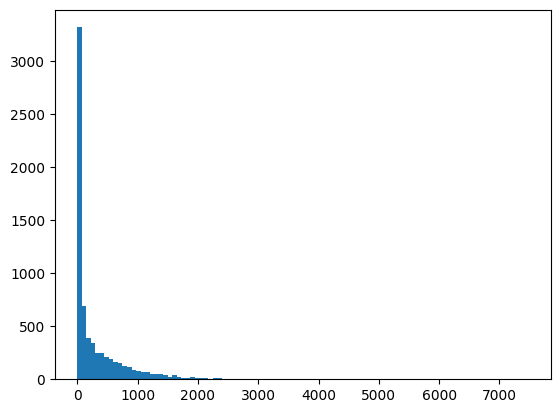

In [ ]:
# Построение гистограммы распределения длин текстов в словах
seq_len = [len(x) for x in txt_se]
plt.hist(seq_len, 100)
plt.show()

Основная масса текстов укладывается в длину около 1200 слов, создадим дополнительно "урезанный" эмбединг

In [ ]:
# Создание матрицы "урезанной" эмбединг последовательности
seq_max_len = 1200
txt_seq_1k = pad_sequences(txt_se, maxlen=seq_max_len, dtype='float32', padding='post', truncating='post', value=0.0)
txt_seq_1k.shape

(6921, 1200)

In [ ]:
# Создание матрицы "полной" эмбединг последовательности
txt_seq = pad_sequences(txt_se, maxlen=None, dtype='float32', padding='post', truncating='pre', value=0.0)
txt_seq.shape

(6921, 7479)

In [ ]:
txt_seq_1k[n]

array([ 243.,  191., 1030., ...,    0.,    0.,    0.], dtype=float32)

In [ ]:
counts = df.count(axis=0)
conditions = round(df.count(axis=0)/len(df)*100,2)
uniques = df.nunique(axis=0)
types = df.dtypes
df_x = pd.concat([counts.to_frame(name='Заполнено строк'), uniques.to_frame(name='Уникальных зн.'), conditions.to_frame(name='Процент заполнения'), types.to_frame(name='Тип данных')], axis= 1 )
df_x

,Заполнено строк,Уникальных зн.,Процент заполнения,Тип данных
Name,6921,3,100.00,object
Имя файла,6921,6921,100.00,object
whisper,6921,5716,100.00,object
Статус,6921,2,100.00,object
Тип,6921,8,100.00,object
Дата и время,6921,6903,100.00,object
Номер абонента,6921,5220,100.00,int64
Длительность звонка,6921,917,100.00,int64
Сотрудник,6920,45,99.99,object
ID посетителя,6921,1750,100.00,int64


## Формирование OHE матрицы

In [ ]:
col_to_ohe = ['Статус','Тип','Сайт','Тип посетителя','Сценарий','Операции','Тип устройства','Первая рекламная кампания']
df[col_to_ohe] = df[col_to_ohe].fillna('Нет данных')   # Дозаполним незаполненные данные
OHE_data, encoders = df_to_ohe(df,col_to_ohe,lst_encoders = {})
OHE_data = OHE_data.astype('float32')
OHE_data.shape

Формирование OneHotEncoder и кодировка колонки Статус - Успешно
Формирование OneHotEncoder и кодировка колонки Тип - Успешно
Формирование OneHotEncoder и кодировка колонки Сайт - Успешно
Формирование OneHotEncoder и кодировка колонки Тип посетителя - Успешно
Формирование OneHotEncoder и кодировка колонки Сценарий - Успешно
Формирование OneHotEncoder и кодировка колонки Операции - Успешно
Формирование OneHotEncoder и кодировка колонки Тип устройства - Успешно
Формирование OneHotEncoder и кодировка колонки Первая рекламная кампания - Успешно


(6921, 146)

## Числовые данные

In [ ]:
# Массив из числовых колонок (которые могут иметь значение)
digit_col = ['Чистая длительность разговора','Номер обращения','ID посетителя']
#digit_col = ['Чистая длительность разговора','Длительность звонка']
df[digit_col] = df[digit_col].fillna(0)       # Дозаполнение если есть незаполненные
df['ID посетителя'] = df['ID посетителя']/100000000       # Понижение разрядноси колонки для более плавной нормализации
x_data = np.array(df[digit_col].values)
x_data = x_data.astype('float32')
print(x_data.shape,'макс. значение - ', x_data.max())
x_data[:20]

(6921, 3) макс. значение -  6927.0


array([[  1.      ,   2.      ,  70.464355],
       [  3.      ,   2.      ,  70.98722 ],
       [ 20.      ,   1.      ,   0.      ],
       [  2.      ,   1.      ,  73.719315],
       [394.      ,   2.      ,  74.34148 ],
       [ 50.      ,   1.      ,  74.34148 ],
       [114.      ,   2.      ,   0.      ],
       [448.      ,  34.      ,   0.      ],
       [ 47.      ,   3.      ,   0.      ],
       [ 53.      ,   4.      ,   0.      ],
       [ 62.      ,   2.      ,   0.      ],
       [ 62.      ,   1.      ,   0.      ],
       [447.      ,  11.      ,  74.34155 ],
       [ 50.      ,   2.      ,   0.      ],
       [ 61.      ,   1.      ,   0.      ],
       [ 40.      ,   6.      ,   0.      ],
       [172.      ,   1.      ,   0.      ],
       [315.      ,   1.      ,   0.      ],
       [ 62.      ,   5.      ,   0.      ],
       [325.      ,   1.      ,   0.      ]], dtype=float32)

In [ ]:
# Нормализация массива
max_val = x_data.max()
x_data = x_data / max_val
x_data[:20]

array([[0.00014436, 0.00028873, 0.01017242],
       [0.00043309, 0.00028873, 0.0102479 ],
       [0.00288725, 0.00014436, 0.        ],
       [0.00028873, 0.00014436, 0.01064231],
       [0.05687888, 0.00028873, 0.01073213],
       [0.00721813, 0.00014436, 0.01073213],
       [0.01645734, 0.00028873, 0.        ],
       [0.06467446, 0.00490833, 0.        ],
       [0.00678504, 0.00043309, 0.        ],
       [0.00765122, 0.00057745, 0.        ],
       [0.00895048, 0.00028873, 0.        ],
       [0.00895048, 0.00014436, 0.        ],
       [0.0645301 , 0.00158799, 0.01073214],
       [0.00721813, 0.00028873, 0.        ],
       [0.00880612, 0.00014436, 0.        ],
       [0.00577451, 0.00086618, 0.        ],
       [0.02483037, 0.00014436, 0.        ],
       [0.04547423, 0.00014436, 0.        ],
       [0.00895048, 0.00072181, 0.        ],
       [0.04691786, 0.00014436, 0.        ]], dtype=float32)

## Выходные тензоры

создадим всех 3-х типов

In [ ]:
target = np.array(df.target.values,dtype='float32')
print(target.shape)
target[:20]

(6921,)


array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0.], dtype=float32)

In [ ]:
targetall = np.array(df.targetall.values,dtype='float32')
print(targetall.shape)
targetall[:20]

(6921,)


array([0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1.], dtype=float32)

In [ ]:
klass = np.array(df.klass.values,dtype='float32')
print(klass.shape)
klass[:20]

(6921,)


array([0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 2.,
       1., 0., 1.], dtype=float32)

In [ ]:
# Сохранение сформированных массивов
with open('/content/drive/MyDrive/Media108/x_y_array.pkl', 'wb') as f:
    pkl.dump([txt_bow, txt_seq, txt_seq_1k, OHE_data, x_data, target, targetall, klass], f)

## Разбивка на обучаюшую, валидационную и тестовую выборки

балансировать будем по колонке 'klass', чтобы всех типов в каждую выборку попало эквивалентное кол-во.

In [ ]:
# Загрузка сохраненных массивов
with open('/content/drive/MyDrive/Media108/x_y_array.pkl', 'rb') as f:
    txt_bow, txt_seq, txt_seq_1k, OHE_data, x_data, target, targetall, klass = pkl.load(f)

In [ ]:
# массивы: txt_bow, txt_seq, txt_seq_1k, OHE_data, x_data, target, targetall, klass
txt_bow_1, txt_bow_val, txt_seq_1, txt_seq_val, txt_seq_1k_1, txt_seq_1k_val, OHE_data_1, OHE_data_val, \
x_data_1, x_data_val, target_1, target_val, targetall_1, targetall_val, klass_1, klass_val\
 = train_test_split(txt_bow, txt_seq, txt_seq_1k, OHE_data, x_data, target, targetall, klass, test_size=0.2, random_state=42, stratify=klass)
txt_bow_train, txt_bow_test, txt_seq_train, txt_seq_test, txt_seq_1k_train, txt_seq_1k_test, OHE_data_train, OHE_data_test, \
x_data_train, x_data_test, target_train, target_test, targetall_train, targetall_test, klass_train, klass_test\
 = train_test_split(txt_bow_1, txt_seq_1, txt_seq_1k_1, OHE_data_1, x_data_1, target_1, targetall_1, klass_1, test_size=0.25, random_state=42, stratify=klass_1)


In [ ]:
txt_bow_train.shape, txt_bow_val.shape, txt_bow_test.shape

((4152, 35000), (1385, 35000), (1384, 35000))

In [ ]:
OHE_data_train.shape, OHE_data_val.shape, OHE_data_test.shape

((4152, 146), (1385, 146), (1384, 146))

In [ ]:
klass_train.shape, klass_val.shape, klass_test.shape

((4152,), (1385,), (1384,))

In [ ]:
# Сохранение токенайзера и енкодеров.
with open('/content/drive/MyDrive/Media108/token_encoders.pkl', 'wb') as f:
    pkl.dump([encoders,tokenizer_txt], f)

## Нейронки:

### Модель 1

In [ ]:
# Колбак
mycolback = ModelCheckpoint('/content/drive/MyDrive/Media108/model9_1.h5',
                        monitor='val_accuracy',
                        verbose=1,
                        mode='max',
                        save_best_only=True)

In [ ]:
# Создание раветвленной модели
input_x1 = Input(shape=(txt_bow.shape[1]), name = 'input_x1')

input_x2 = Input(shape=(OHE_data.shape[1]), name = 'input_x2')

input_x3 = Input(shape=(x_data.shape[1]), name = 'input_x3')

x1 = Dense(500, activation = 'relu') (input_x1)
x1 = BatchNormalization() (x1)
x1 = Dropout(0.6) (x1)
#x1 = Dense(128, activation = 'relu') (x1)
#x1 = Dropout(0.5) (x1)
x1 = Dense(32, activation = 'relu') (x1)

x2 = Dense(48, activation = 'relu') (input_x2)
x2 = BatchNormalization() (x2)
x2 = Dropout(0.6) (x2)
#x2 = Dense(32, activation = 'relu') (x2)
#x2 = Dropout(0.5) (x2)
x2 = Dense(16, activation = 'relu') (x2)

x3 = Dense(32, activation = 'relu') (input_x3)
x3 = BatchNormalization() (x3)
x3 = Dropout(0.6) (x3)
x3 = Dense(16, activation = 'relu') (x3)

x = concatenate([x1, x2, x3])
x = BatchNormalization() (x)
x = Dense(16, activation='relu') (x)

x = Dropout(0.6) (x)

output = Dense(1, activation='sigmoid', name = 'output') (x)

model = Model ([input_x1, input_x2, input_x3], output)

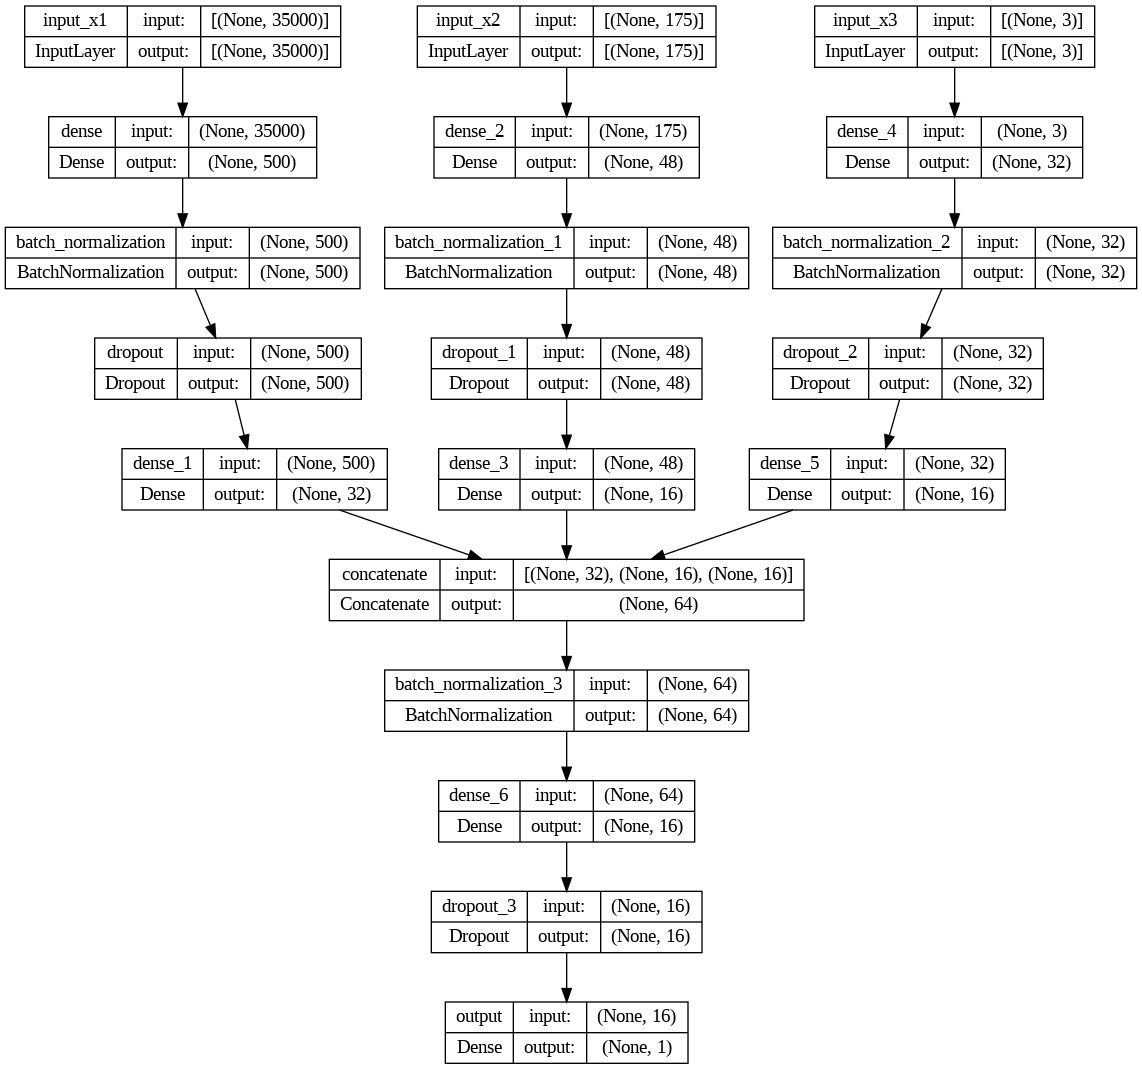

In [ ]:
# Её структура
utils.plot_model(model, show_shapes=True)

In [ ]:
# Компиляция и обучение
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history1 = model.fit({'input_x1':txt_bow_train,'input_x2':OHE_data_train,'input_x3':x_data_train}, target_train, batch_size=32, validation_data=({'input_x1':txt_bow_val,'input_x2':OHE_data_val,'input_x3':x_data_val},target_val), epochs=10, verbose=1, callbacks=mycolback, shuffle=True)

Epoch 1/10
130/130 [==============================] - ETA: 0s - loss: 0.8893 - accuracy: 0.5501
Epoch 1: val_accuracy improved from -inf to 0.32852, saving model to /content/drive/MyDrive/Media108/model9_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


130/130 [==============================] - 26s 176ms/step - loss: 0.8893 - accuracy: 0.5501 - val_loss: 0.7618 - val_accuracy: 0.3285
Epoch 2/10
130/130 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.6488
Epoch 2: val_accuracy improved from 0.32852 to 0.58267, saving model to /content/drive/MyDrive/Media108/model9_1.h5
130/130 [==============================] - 28s 218ms/step - loss: 0.6957 - accuracy: 0.6488 - val_loss: 0.6170 - val_accuracy: 0.5827
Epoch 3/10
130/130 [==============================] - ETA: 0s - loss: 0.5845 - accuracy: 0.7192
Epoch 3: val_accuracy improved from 0.58267 to 0.83032, saving model to /content/drive/MyDrive/Media108/model9_1.h5
130/130 [==============================] - 29s 224ms/step - loss: 0.5845 - accuracy: 0.7192 - val_loss: 0.4586 - val_accuracy: 0.8303
Epoch 4/10
130/130 [==============================] - ETA: 0s - loss: 0.5002 - accuracy: 0.7806
Epoch 4: val_accuracy improved from 0.83032 to 0.87365, saving model to /conte

In [ ]:
# Компиляция и дообучение
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
history2 = model.fit({'input_x1':txt_bow_train,'input_x2':OHE_data_train,'input_x3':x_data_train}, target_train, batch_size=48, validation_data=({'input_x1':txt_bow_val,'input_x2':OHE_data_val,'input_x3':x_data_val},target_val), epochs=10, verbose=1, callbacks=mycolback, shuffle=True)

Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9338
Epoch 1: val_accuracy did not improve from 0.90686
87/87 [==============================] - 18s 190ms/step - loss: 0.2284 - accuracy: 0.9338 - val_loss: 0.2599 - val_accuracy: 0.9069
Epoch 2/10
87/87 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9386
Epoch 2: val_accuracy did not improve from 0.90686
87/87 [==============================] - 16s 187ms/step - loss: 0.2288 - accuracy: 0.9386 - val_loss: 0.2596 - val_accuracy: 0.9061
Epoch 3/10
87/87 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9350
Epoch 3: val_accuracy improved from 0.90686 to 0.90830, saving model to /content/drive/MyDrive/Media108/model9_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 28s 323ms/step - loss: 0.2289 - accuracy: 0.9350 - val_loss: 0.2591 - val_accuracy: 0.9083
Epoch 4/10
87/87 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9391
Epoch 4: val_accuracy did not improve from 0.90830
87/87 [==============================] - 17s 197ms/step - loss: 0.2142 - accuracy: 0.9391 - val_loss: 0.2580 - val_accuracy: 0.9076
Epoch 5/10
87/87 [==============================] - ETA: 0s - loss: 0.2173 - accuracy: 0.9436
Epoch 5: val_accuracy did not improve from 0.90830
87/87 [==============================] - 17s 191ms/step - loss: 0.2173 - accuracy: 0.9436 - val_loss: 0.2577 - val_accuracy: 0.9069
Epoch 6/10
87/87 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9434
Epoch 6: val_accuracy did not improve from 0.90830
87/87 [==============================] - 18s 202ms/step - loss: 0.2128 - accuracy: 0.9434 - val_loss: 0.2558 - val_accuracy: 0.9069
Epoch 7/10
87/87 [===================

In [ ]:
model.save(path_dir+'model9_1_los2547')

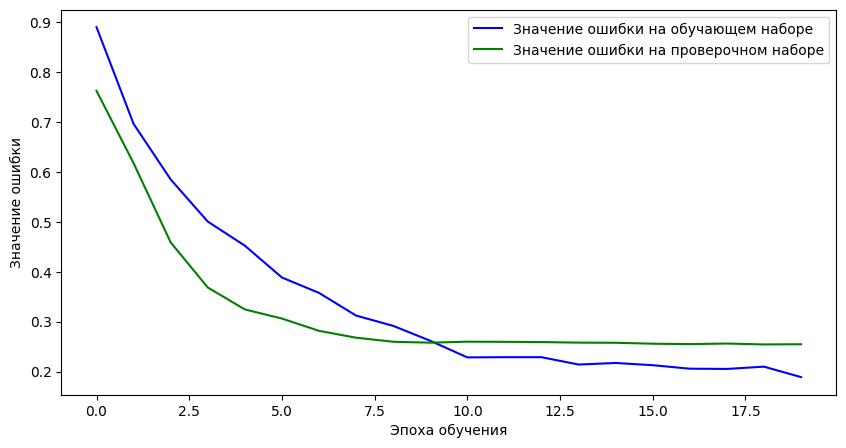

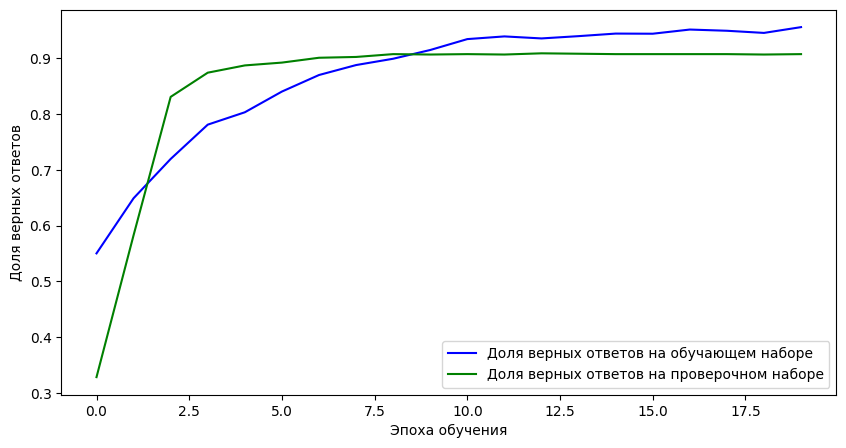

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history1.history['loss']+history2.history['loss'],
         label='Значение ошибки на обучающем наборе',color='b')
plt.plot(history1.history['val_loss']+history2.history['val_loss'],
         label='Значение ошибки на проверочном наборе',color='g')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
#plt.style.use('ggplot')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения метрика "accuracy"
plt.figure(figsize = (10, 5))
plt.plot(history1.history['accuracy']+history2.history['accuracy'],
         label='Доля верных ответов на обучающем наборе',color='b')
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе',color='g')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='lower right')
plt.show()

### Модель 2

In [ ]:
# Колбак
mycolback2 = ModelCheckpoint('/content/drive/MyDrive/Media108/model9_21.h5',
                        monitor='val_accuracy',
                        verbose=1,
                        mode='max',
                        save_best_only=True)

mycolback = ModelCheckpoint('/content/drive/MyDrive/Media108/model9_21_los.h5',
                        monitor='val_loss',
                        verbose=1,
                        mode='min',
                        save_best_only=True)

In [ ]:
txt_bow_train = txt_bow_train.astype('float32')
txt_bow_val = txt_bow_val.astype('float32')
#x_data = x_data
x_data_train = x_data_train.astype('float32')
x_data_val = x_data_val.astype('float32')
OHE_data_train = OHE_data_train.astype('float32')
OHE_data_val = OHE_data_val.astype('float32')
targetall_train = target_train.astype('float32')
targetall_val = target_val.astype('float32')
target_train = target_train.astype('float32')
target_val = target_val.astype('float32')

In [ ]:
# Создание раветвленной модели
input_x1 = Input(shape=(txt_bow.shape[1]), name = 'input_x1')

input_x2 = Input(shape=(OHE_data.shape[1]), name = 'input_x2')

input_x3 = Input(shape=(x_data.shape[1]), name = 'input_x3')

x1 = Dense(500, activation = 'relu') (input_x1)
x1 = BatchNormalization() (x1)
x1 = Dropout(0.6) (x1)
#x1 = Dense(128, activation = 'relu') (x1)
#x1 = Dropout(0.5) (x1)
x1 = Dense(32, activation = 'relu') (x1)

x2 = Dense(48, activation = 'relu') (input_x2)
x2 = BatchNormalization() (x2)
x2 = Dropout(0.6) (x2)
#x2 = Dense(32, activation = 'relu') (x2)
#x2 = Dropout(0.5) (x2)
x2 = Dense(16, activation = 'relu') (x2)

x3 = Dense(32, activation = 'relu') (input_x3)
x3 = BatchNormalization() (x3)
x3 = Dropout(0.6) (x3)
x3 = Dense(16, activation = 'relu') (x3)

x = concatenate([x1, x2, x3])
x = BatchNormalization() (x)
x = Dense(16, activation='relu') (x)

x = Dropout(0.6) (x)

output = Dense(1, activation='sigmoid', name = 'output') (x)

model2 = Model ([input_x1, input_x2, input_x3], output)

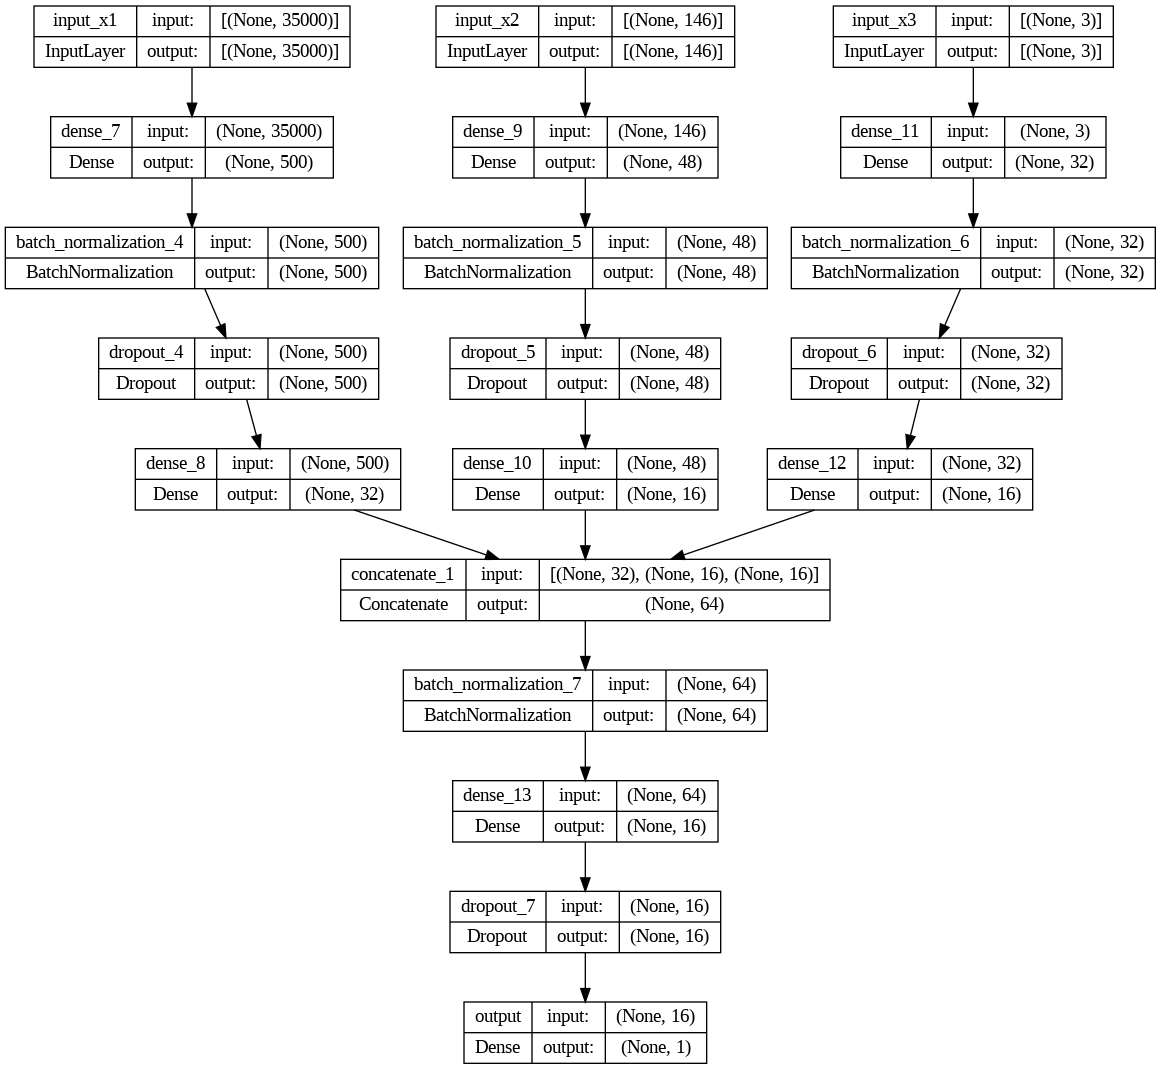

In [ ]:
# Её структура
utils.plot_model(model2, show_shapes=True)

In [ ]:
# Компиляция и обучение
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['F1Score','accuracy'])
history1 = model2.fit({'input_x1':txt_bow_train,'input_x2':OHE_data_train,'input_x3':x_data_train}, targetall_train, batch_size=32, validation_data=({'input_x1':txt_bow_val,'input_x2':OHE_data_val,'input_x3':x_data_val},targetall_val), epochs=10, verbose=1, callbacks=[mycolback2,mycolback], shuffle=True)

Epoch 1/10
129/130 [============================>.] - ETA: 0s - loss: 0.6248 - f1_score: 0.4945 - accuracy: 0.6955
Epoch 1: val_accuracy improved from -inf to 0.74368, saving model to /content/drive/MyDrive/Media108/model9_21.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: val_loss improved from inf to 0.60181, saving model to /content/drive/MyDrive/Media108/model9_21_los.h5
130/130 [==============================] - 17s 98ms/step - loss: 0.6240 - f1_score: 0.4946 - accuracy: 0.6963 - val_loss: 0.6018 - val_f1_score: 0.4946 - val_accuracy: 0.7437
Epoch 2/10
128/130 [============================>.] - ETA: 0s - loss: 0.5020 - f1_score: 0.4961 - accuracy: 0.7727
Epoch 2: val_accuracy improved from 0.74368 to 0.87148, saving model to /content/drive/MyDrive/Media108/model9_21.h5

Epoch 2: val_loss improved from 0.60181 to 0.45093, saving model to /content/drive/MyDrive/Media108/model9_21_los.h5
130/130 [==============================] - 6s 50ms/step - loss: 0.5008 - f1_score: 0.4946 - accuracy: 0.7738 - val_loss: 0.4509 - val_f1_score: 0.4946 - val_accuracy: 0.8715
Epoch 3/10
130/130 [==============================] - ETA: 0s - loss: 0.4242 - f1_score: 0.4946 - accuracy: 0.8206
Epoch 3: val_accuracy improved from 0.87148 to 0.89170, saving model to 

In [ ]:
# Компиляция и дообучение
model2 = load_model('/content/drive/MyDrive/Media108/model9_21.h5')
model2.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['F1Score','accuracy'])
history2 = model2.fit({'input_x1':txt_bow_train,'input_x2':OHE_data_train,'input_x3':x_data_train}, targetall_train, batch_size=48, validation_data=({'input_x1':txt_bow_val,'input_x2':OHE_data_val,'input_x3':x_data_val},targetall_val), epochs=10, verbose=1, callbacks=[mycolback2,mycolback], shuffle=True)

Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 0.1612 - f1_score: 0.4946 - accuracy: 0.9530
Epoch 1: val_accuracy did not improve from 0.90975

Epoch 1: val_loss did not improve from 0.23249
87/87 [==============================] - 6s 26ms/step - loss: 0.1612 - f1_score: 0.4946 - accuracy: 0.9530 - val_loss: 0.2360 - val_f1_score: 0.4946 - val_accuracy: 0.9076
Epoch 2/10
85/87 [============================>.] - ETA: 0s - loss: 0.1565 - f1_score: 0.4970 - accuracy: 0.9561
Epoch 2: val_accuracy did not improve from 0.90975

Epoch 2: val_loss did not improve from 0.23249
87/87 [==============================] - 1s 16ms/step - loss: 0.1567 - f1_score: 0.4946 - accuracy: 0.9557 - val_loss: 0.2364 - val_f1_score: 0.4946 - val_accuracy: 0.9076
Epoch 3/10
85/87 [============================>.] - ETA: 0s - loss: 0.1506 - f1_score: 0.4945 - accuracy: 0.9598
Epoch 3: val_accuracy did not improve from 0.90975

Epoch 3: val_loss did not improve from 0.23249
87/87 [=============

In [ ]:
model2.save('/content/drive/MyDrive/Media108/model9_22_1.keras')

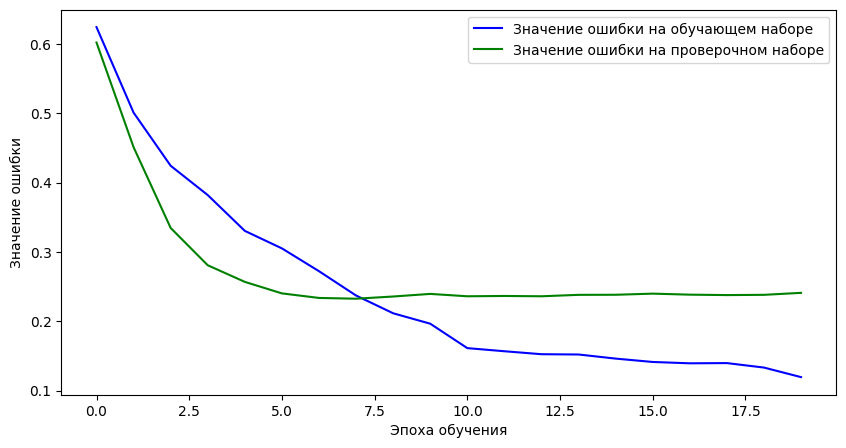

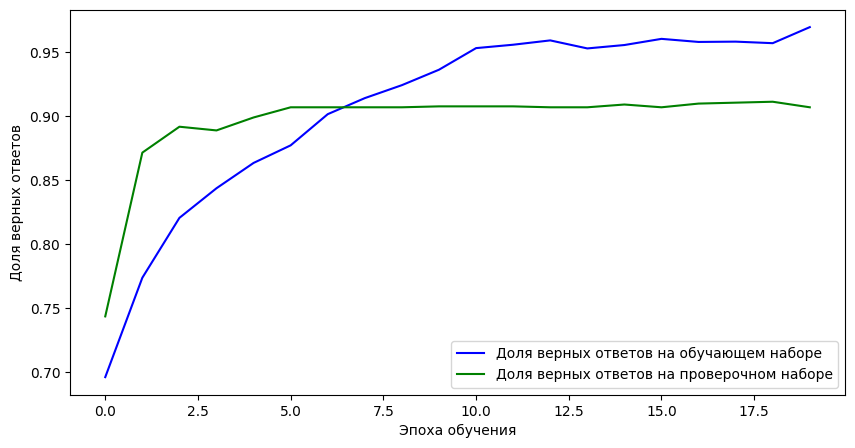

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history1.history['loss']+history2.history['loss'],
         label='Значение ошибки на обучающем наборе',color='b')
plt.plot(history1.history['val_loss']+history2.history['val_loss'],
         label='Значение ошибки на проверочном наборе',color='g')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
#plt.style.use('ggplot')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения метрика "accuracy"
plt.figure(figsize = (10, 5))
plt.plot(history1.history['accuracy']+history2.history['accuracy'],
         label='Доля верных ответов на обучающем наборе',color='b')
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе',color='g')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='lower right')
plt.show()

### Модель 3

Обучение по колонке targetall

In [ ]:
# Колбак
mycolback3 = ModelCheckpoint('/content/drive/MyDrive/Media108/model9_3.h5',
                        monitor='val_accuracy',
                        verbose=1,
                        mode='max',
                        save_best_only=True)

In [ ]:
txt_bow_train = txt_bow_train.astype('float32')
txt_bow_val = txt_bow_val.astype('float32')
#x_data = x_data
x_data_train = x_data_train.astype('float32')
x_data_val = x_data_val.astype('float32')
OHE_data_train = OHE_data_train.astype('float32')
OHE_data_val = OHE_data_val.astype('float32')
targetall_train = target_train.astype('float32')
targetall_val = target_val.astype('float32')

In [ ]:
# Создание раветвленной модели
input_x1 = Input(shape=(txt_bow.shape[1]), name = 'input_x1')

input_x2 = Input(shape=(OHE_data.shape[1]), name = 'input_x2')

input_x3 = Input(shape=(x_data.shape[1]), name = 'input_x3')

x1 = Dense(500, activation = 'relu') (input_x1)
x1 = BatchNormalization() (x1)
x1 = Dropout(0.6) (x1)
#x1 = Dense(128, activation = 'relu') (x1)
#x1 = Dropout(0.5) (x1)
x1 = Dense(32, activation = 'relu') (x1)

x2 = Dense(48, activation = 'relu') (input_x2)
x2 = BatchNormalization() (x2)
x2 = Dropout(0.6) (x2)
#x2 = Dense(32, activation = 'relu') (x2)
#x2 = Dropout(0.5) (x2)
x2 = Dense(16, activation = 'relu') (x2)

x3 = Dense(32, activation = 'relu') (input_x3)
x3 = BatchNormalization() (x3)
x3 = Dropout(0.6) (x3)
x3 = Dense(16, activation = 'relu') (x3)

x = concatenate([x1, x2, x3])
x = BatchNormalization() (x)
x = Dense(16, activation='relu') (x)

x = Dropout(0.6) (x)

output = Dense(1, activation='sigmoid', name = 'output') (x)

model3 = Model ([input_x1, input_x2, input_x3], output)

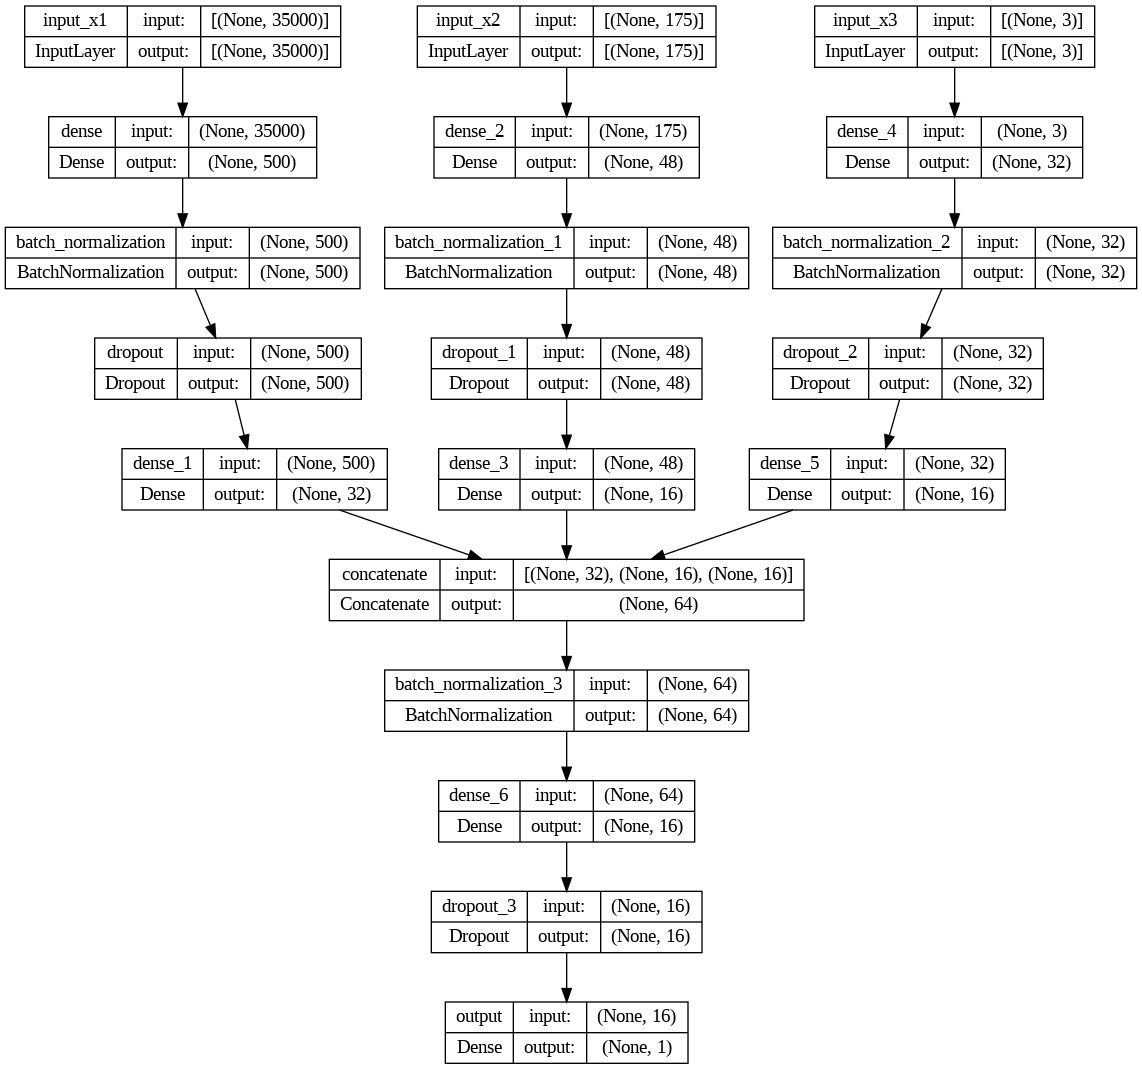

In [ ]:
# Её структура
utils.plot_model(model3, show_shapes=True)

In [ ]:
# Компиляция и обучение
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['F1Score','accuracy'])
history1 = model3.fit({'input_x1':txt_bow_train,'input_x2':OHE_data_train,'input_x3':x_data_train}, targetall_train, batch_size=32, validation_data=({'input_x1':txt_bow_val,'input_x2':OHE_data_val,'input_x3':x_data_val},targetall_val), epochs=10, verbose=1, callbacks=mycolback3, shuffle=True)

Epoch 1/10
130/130 [==============================] - ETA: 0s - loss: 0.8896 - f1_score: 0.4946 - accuracy: 0.5523
Epoch 1: val_accuracy improved from -inf to 0.32852, saving model to /content/drive/MyDrive/Media108/model9_3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


130/130 [==============================] - 54s 385ms/step - loss: 0.8896 - f1_score: 0.4946 - accuracy: 0.5523 - val_loss: 0.7597 - val_f1_score: 0.4946 - val_accuracy: 0.3285
Epoch 2/10
130/130 [==============================] - ETA: 0s - loss: 0.6915 - f1_score: 0.4946 - accuracy: 0.6513
Epoch 2: val_accuracy improved from 0.32852 to 0.58773, saving model to /content/drive/MyDrive/Media108/model9_3.h5
130/130 [==============================] - 52s 398ms/step - loss: 0.6915 - f1_score: 0.4946 - accuracy: 0.6513 - val_loss: 0.6132 - val_f1_score: 0.4946 - val_accuracy: 0.5877
Epoch 3/10
130/130 [==============================] - ETA: 0s - loss: 0.5919 - f1_score: 0.4946 - accuracy: 0.7187
Epoch 3: val_accuracy improved from 0.58773 to 0.83755, saving model to /content/drive/MyDrive/Media108/model9_3.h5
130/130 [==============================] - 51s 390ms/step - loss: 0.5919 - f1_score: 0.4946 - accuracy: 0.7187 - val_loss: 0.4567 - val_f1_score: 0.4946 - val_accuracy: 0.8375
Epoch 4/10

In [ ]:
# Компиляция и дообучение
model3 = load_model('/content/drive/MyDrive/Media108/model9_3.h5')
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['F1Score','accuracy'])
history2 = model3.fit({'input_x1':txt_bow_train,'input_x2':OHE_data_train,'input_x3':x_data_train}, targetall_train, batch_size=24, validation_data=({'input_x1':txt_bow_val,'input_x2':OHE_data_val,'input_x3':x_data_val},targetall_val), epochs=10, verbose=1, callbacks=mycolback3, shuffle=True)

Epoch 1/10
173/173 [==============================] - ETA: 0s - loss: 0.2264 - f1_score: 0.4946 - accuracy: 0.9297
Epoch 1: val_accuracy did not improve from 0.90758
173/173 [==============================] - 60s 329ms/step - loss: 0.2264 - f1_score: 0.4946 - accuracy: 0.9297 - val_loss: 0.2460 - val_f1_score: 0.4946 - val_accuracy: 0.9061
Epoch 2/10
173/173 [==============================] - ETA: 0s - loss: 0.2080 - f1_score: 0.4946 - accuracy: 0.9434
Epoch 2: val_accuracy improved from 0.90758 to 0.90903, saving model to /content/drive/MyDrive/Media108/model9_3.h5
173/173 [==============================] - 59s 342ms/step - loss: 0.2080 - f1_score: 0.4946 - accuracy: 0.9434 - val_loss: 0.2474 - val_f1_score: 0.4946 - val_accuracy: 0.9090
Epoch 3/10
173/173 [==============================] - ETA: 0s - loss: 0.2022 - f1_score: 0.4946 - accuracy: 0.9465
Epoch 3: val_accuracy did not improve from 0.90903
173/173 [==============================] - 64s 373ms/step - loss: 0.2022 - f1_score: 

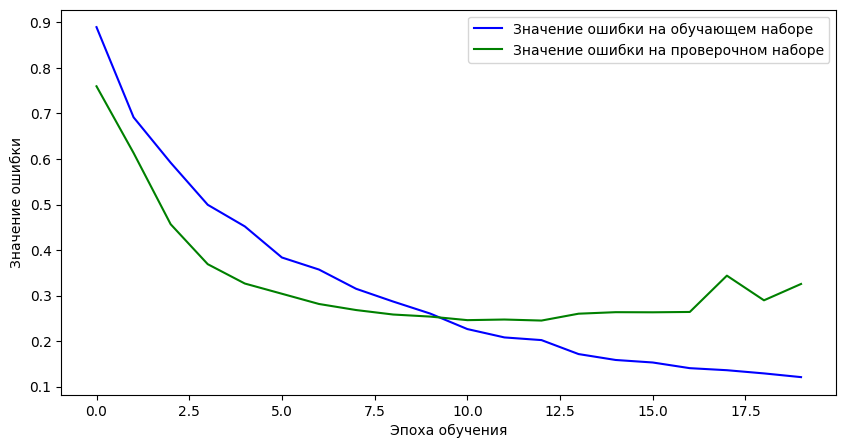

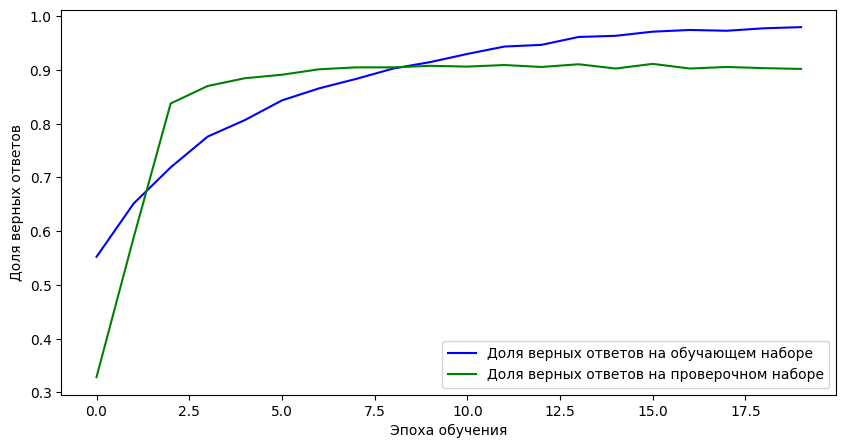

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history1.history['loss']+history2.history['loss'],
         label='Значение ошибки на обучающем наборе',color='b')
plt.plot(history1.history['val_loss']+history2.history['val_loss'],
         label='Значение ошибки на проверочном наборе',color='g')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
#plt.style.use('ggplot')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения метрика "accuracy"
plt.figure(figsize = (10, 5))
plt.plot(history1.history['accuracy']+history2.history['accuracy'],
         label='Доля верных ответов на обучающем наборе',color='b')
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе',color='g')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='lower right')
plt.show()

### Модель 4
добавляем 4-й вход (Эмбединги)

In [ ]:
# Колбак
mycolback4 = ModelCheckpoint('/content/drive/MyDrive/Media108/model9_4_1.h5',
                        monitor='val_accuracy',
                        verbose=1,
                        mode='max',
                        save_best_only=True)

In [ ]:
txt_bow_train = txt_bow_train.astype('float32')
txt_bow_val = txt_bow_val.astype('float32')

x_data_train = x_data_train.astype('float32')
x_data_val = x_data_val.astype('float32')

OHE_data_train = OHE_data_train.astype('float32')
OHE_data_val = OHE_data_val.astype('float32')

#txt_seq_train = txt_seq_train.astype('int32')
#txt_seq_val = txt_seq_val.astype('int32')

target_train = target_train.astype('float32')
target_val = target_val.astype('float32')

In [ ]:
# Создание раветвленной модели
input_x1 = Input(shape=(txt_bow.shape[1]), name='input_x1')

input_x2 = Input(shape=(OHE_data.shape[1]), name='input_x2')

input_x3 = Input(shape=(x_data.shape[1]), name='input_x3')

input_x4 = Input(shape=(txt_seq_1k.shape[1]), name='input_x4')

x1 = Dense(500, activation = 'relu') (input_x1)
x1 = BatchNormalization() (x1)
x1 = Dropout(0.6) (x1)
x1 = Dense(32, activation = 'relu') (x1)

x2 = Dense(48, activation = 'relu') (input_x2)
x2 = BatchNormalization() (x2)
x2 = Dropout(0.6) (x2)
x2 = Dense(16, activation = 'relu') (x2)

x3 = Dense(32, activation = 'relu') (input_x3)
x3 = BatchNormalization() (x3)
x3 = Dropout(0.6) (x3)
x3 = Dense(16, activation = 'relu') (x3)

x4 = Embedding(input_dim = 35000, output_dim = 40, input_length = txt_seq_1k.shape[1]) (input_x4)
x4 = SpatialDropout1D(0.4 , name = 'Dropout1_x4') (x4)
x4 = BatchNormalization() (x4)
x4 = Conv1D(20, 5, activation='relu') (x4)
x4 = Conv1D(10, 5, activation='relu') (x4)
x4 = MaxPool1D(2) (x4)
x4 = Flatten(name = 'Flatten1_x1') (x4)
x4 = Dropout(0.4) (x4)
x4 = Dense(32, activation = 'relu') (x4)

xx = add([x1,x4])
xx = BatchNormalization() (xx)

xy = add([x2,x3])
xy = BatchNormalization() (xy)

x = concatenate([xx, xy])
#x = BatchNormalization() (x)
x = Dense(16, activation='relu') (x)
x = Dropout(0.6) (x)

output = Dense(1, activation='sigmoid', name = 'output') (x)

model4 = Model ([input_x1, input_x2, input_x3, input_x4], output)

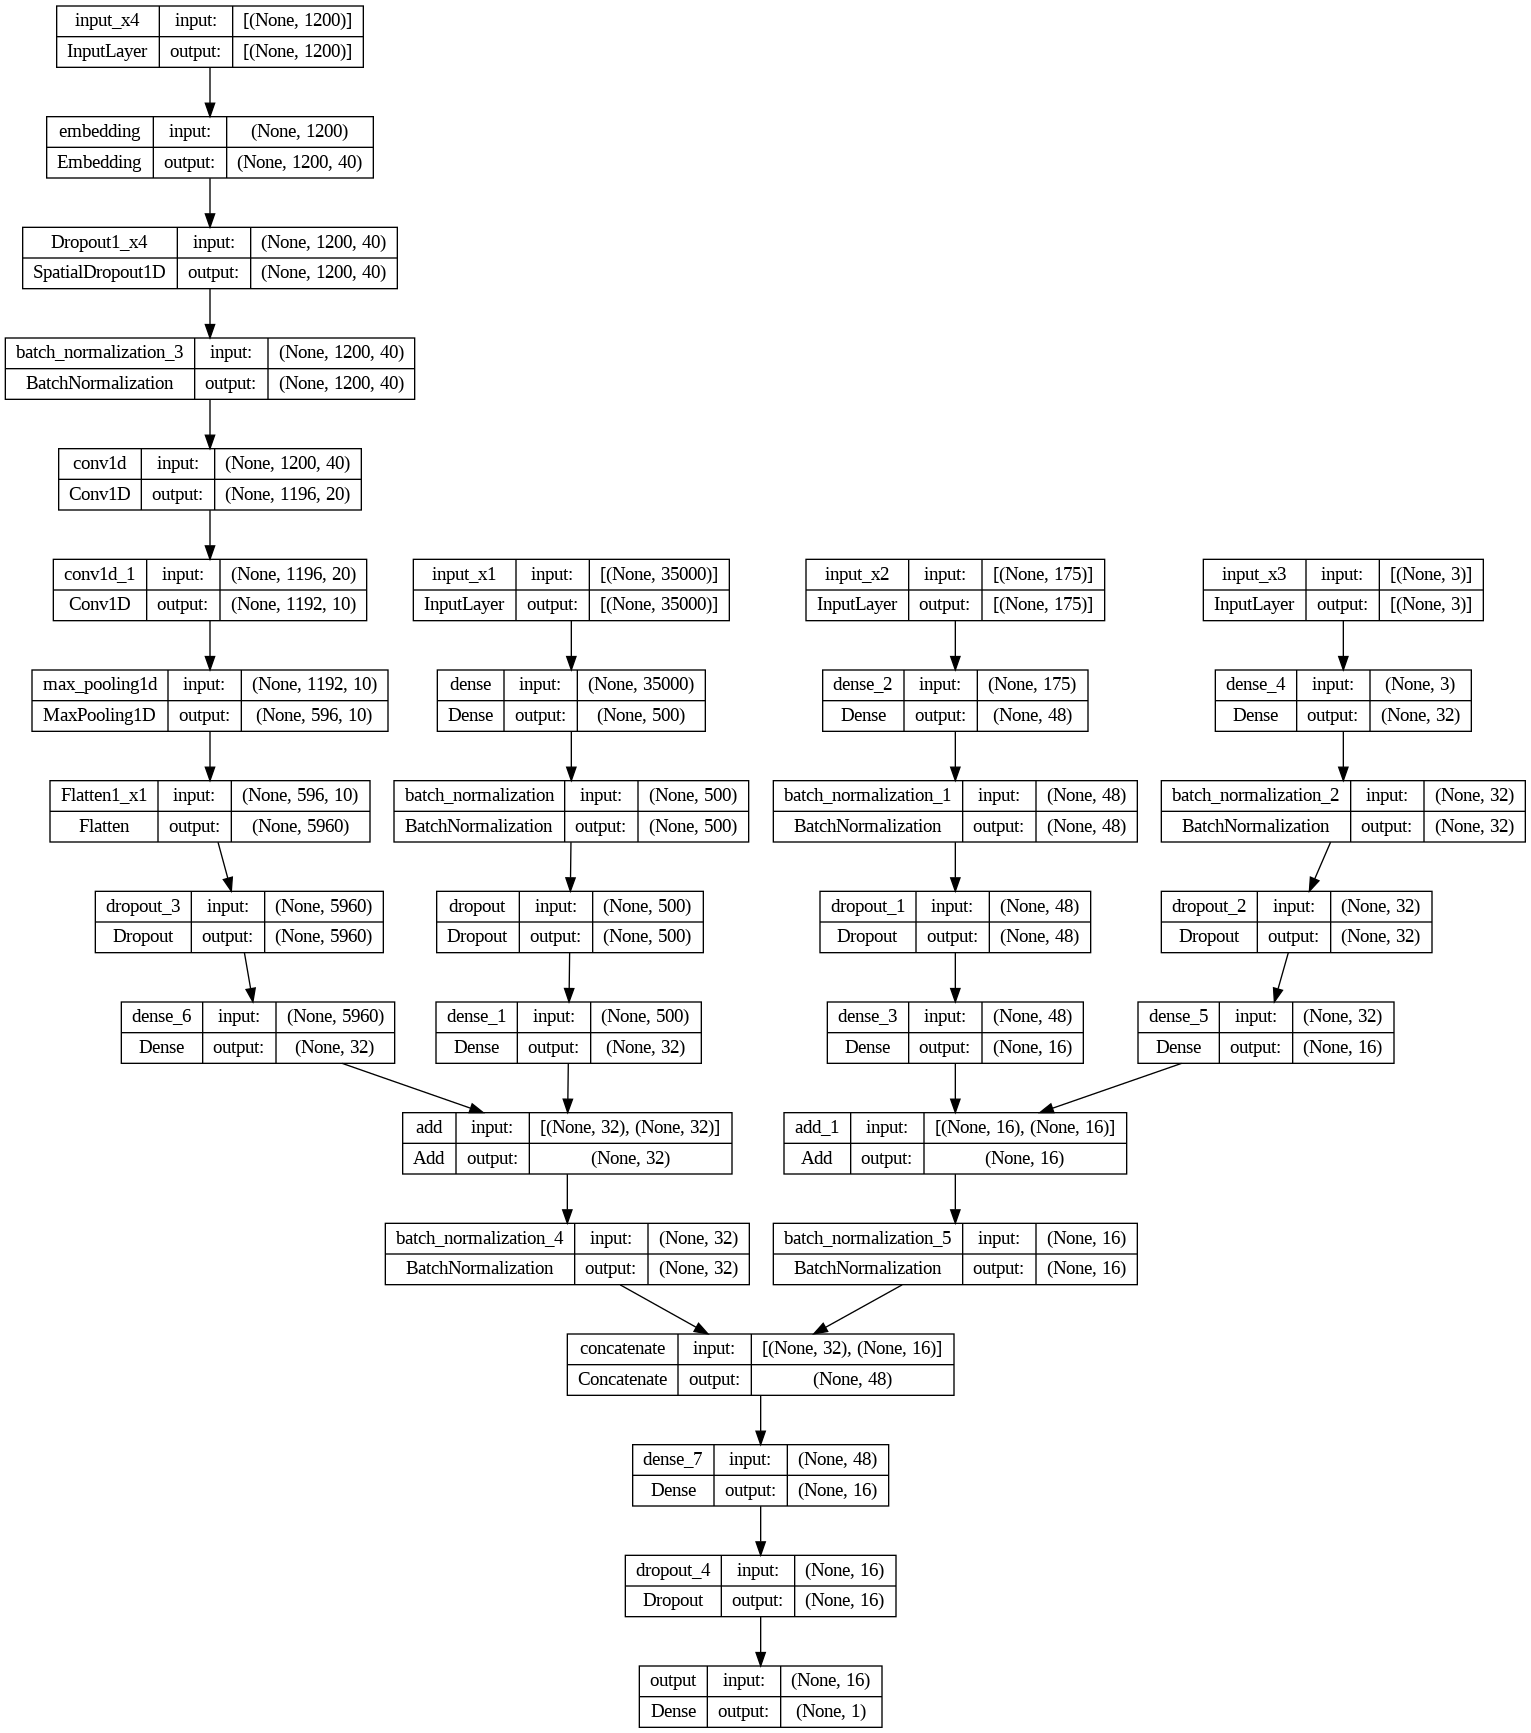

In [ ]:
# Её структура
utils.plot_model(model4, show_shapes=True)

In [ ]:
# Компиляция и обучение
model4.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=[F1Score(),'accuracy'])
history1 = model4.fit({'input_x1':txt_bow_train,'input_x2':OHE_data_train,'input_x3':x_data_train,'input_x4':txt_seq_1k_train}, targetall_train, batch_size=32, validation_data=({'input_x1':txt_bow_val,'input_x2':OHE_data_val,'input_x3':x_data_val,'input_x4':txt_seq_1k_val},targetall_val), epochs=10, verbose=1, callbacks=mycolback4, shuffle=True)

Epoch 1/10
130/130 [==============================] - ETA: 0s - loss: 0.9066 - f1_score: 0.6139 - accuracy: 0.5874
Epoch 1: val_accuracy improved from -inf to 0.50903, saving model to /content/drive/MyDrive/Media108/model9_4_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


130/130 [==============================] - 41s 156ms/step - loss: 0.9066 - f1_score: 0.6139 - accuracy: 0.5874 - val_loss: 0.6814 - val_f1_score: 0.6143 - val_accuracy: 0.5090
Epoch 2/10
130/130 [==============================] - ETA: 0s - loss: 0.7490 - f1_score: 0.6139 - accuracy: 0.6339
Epoch 2: val_accuracy improved from 0.50903 to 0.68448, saving model to /content/drive/MyDrive/Media108/model9_4_1.h5
130/130 [==============================] - 19s 146ms/step - loss: 0.7490 - f1_score: 0.6139 - accuracy: 0.6339 - val_loss: 0.6258 - val_f1_score: 0.6143 - val_accuracy: 0.6845
Epoch 3/10
130/130 [==============================] - ETA: 0s - loss: 0.6693 - f1_score: 0.6139 - accuracy: 0.6792
Epoch 3: val_accuracy improved from 0.68448 to 0.82744, saving model to /content/drive/MyDrive/Media108/model9_4_1.h5
130/130 [==============================] - 20s 158ms/step - loss: 0.6693 - f1_score: 0.6139 - accuracy: 0.6792 - val_loss: 0.5154 - val_f1_score: 0.6143 - val_accuracy: 0.8274
Epoch 

In [ ]:
# Компиляция и дообучение
model4 = load_model('/content/drive/MyDrive/Media108/model9_4_1.h5')
model4.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=[F1Score(),'accuracy'])
history2 = model4.fit({'input_x1':txt_bow_train,'input_x2':OHE_data_train,'input_x3':x_data_train,'input_x4':txt_seq_1k_train}, targetall_train, batch_size=48, validation_data=({'input_x1':txt_bow_val,'input_x2':OHE_data_val,'input_x3':x_data_val,'input_x4':txt_seq_1k_val},targetall_val), epochs=10, verbose=1, callbacks=mycolback4, shuffle=True)

Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 0.1748 - f1_score: 0.6139 - accuracy: 0.9494
Epoch 1: val_accuracy improved from 0.90036 to 0.90181, saving model to /content/drive/MyDrive/Media108/model9_4_1.h5
87/87 [==============================] - 25s 206ms/step - loss: 0.1748 - f1_score: 0.6139 - accuracy: 0.9494 - val_loss: 0.2749 - val_f1_score: 0.6143 - val_accuracy: 0.9018
Epoch 2/10
87/87 [==============================] - ETA: 0s - loss: 0.1585 - f1_score: 0.6139 - accuracy: 0.9583
Epoch 2: val_accuracy improved from 0.90181 to 0.90325, saving model to /content/drive/MyDrive/Media108/model9_4_1.h5
87/87 [==============================] - 42s 490ms/step - loss: 0.1585 - f1_score: 0.6139 - accuracy: 0.9583 - val_loss: 0.2802 - val_f1_score: 0.6143 - val_accuracy: 0.9032
Epoch 3/10
87/87 [==============================] - ETA: 0s - loss: 0.1717 - f1_score: 0.6139 - accuracy: 0.9501
Epoch 3: val_accuracy did not improve from 0.90325
87/87 [===================

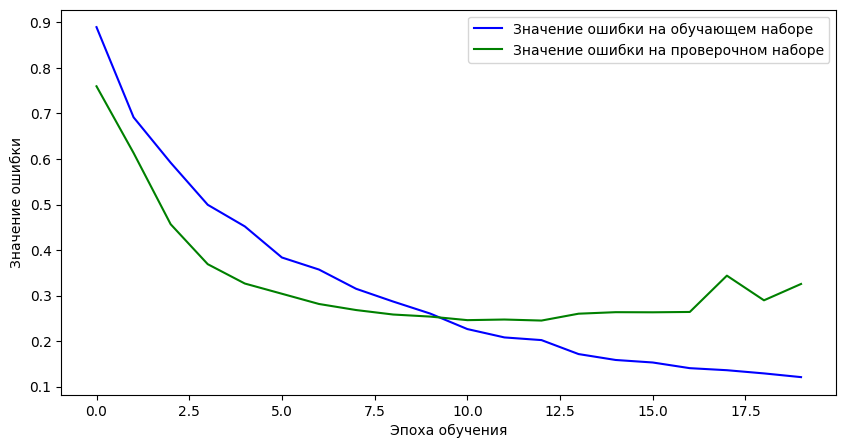

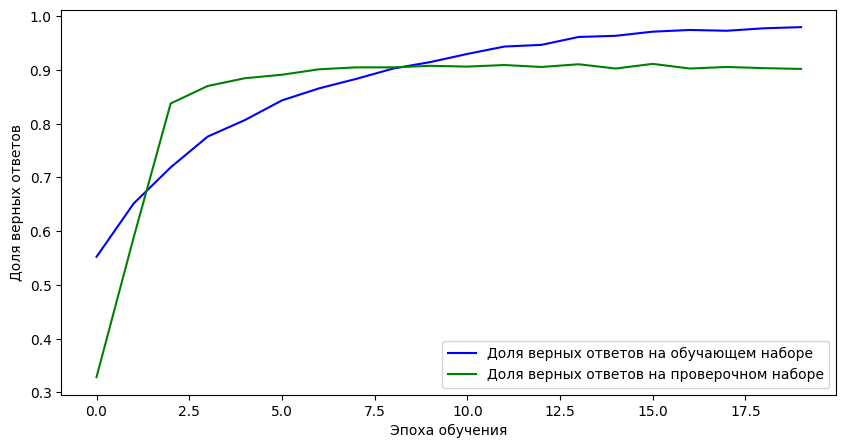

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(history1.history['loss']+history2.history['loss'],
         label='Значение ошибки на обучающем наборе',color='b')
plt.plot(history1.history['val_loss']+history2.history['val_loss'],
         label='Значение ошибки на проверочном наборе',color='g')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
#plt.style.use('ggplot')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения метрика "accuracy"
plt.figure(figsize = (10, 5))
plt.plot(history1.history['accuracy']+history2.history['accuracy'],
         label='Доля верных ответов на обучающем наборе',color='b')
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе',color='g')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(loc='lower right')
plt.show()

## Проверка моделей

In [ ]:
model2 = load_model('/content/drive/MyDrive/Media108/model9_21.h5')
# Предсказание для тестовой выборки
y_pred = model2.predict({'input_x1':txt_bow_test,'input_x2':OHE_data_test,'input_x3':x_data_test}, batch_size=txt_bow_test.shape[0])

1/1 [==============================] - 4s 4s/step


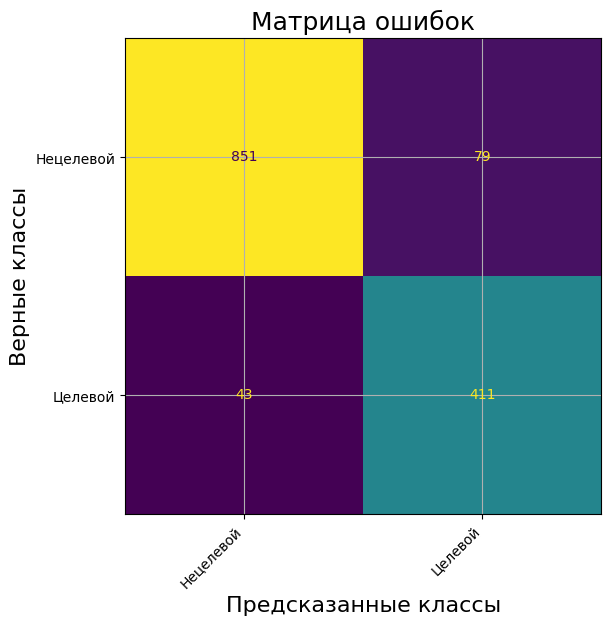

In [ ]:
# Построение матрицы ошибок
cm = confusion_matrix(target_test,
                      np.rint(y_pred))

# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title(f'Матрица ошибок', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Нецелевой','Целевой'])
disp.plot(ax=ax)
plt.style.use('fivethirtyeight')
plt.grid(None)
plt.gca().images[-1].colorbar.remove()
plt.xlabel('Предсказанные классы', fontsize=16)
plt.ylabel('Верные классы', fontsize=16)
fig.autofmt_xdate(rotation=45)
plt.show()

In [ ]:
print(classification_report(target_test,np.rint(y_pred)))

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93       930
         1.0       0.84      0.91      0.87       454

    accuracy                           0.91      1384
   macro avg       0.90      0.91      0.90      1384
weighted avg       0.91      0.91      0.91      1384



In [ ]:
# Предсказание для всего датасета
y_pred = model2.predict({'input_x1':txt_bow,'input_x2':OHE_data,'input_x3':x_data}, batch_size=txt_bow.shape[0])

1/1 [==============================] - 2s 2s/step


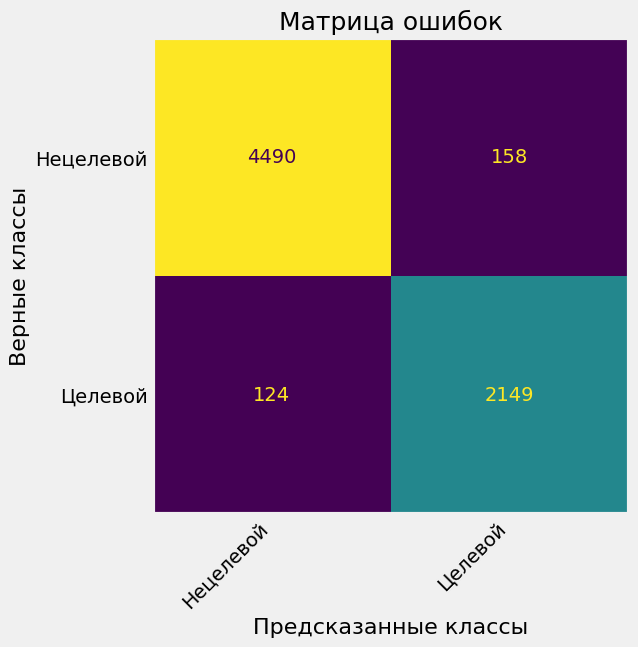

In [ ]:
# Построение матрицы ошибок
cm = confusion_matrix(target,
                      np.rint(y_pred))

# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title(f'Матрица ошибок', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Нецелевой','Целевой'])
disp.plot(ax=ax)
plt.style.use('fivethirtyeight')
plt.grid(None)
plt.gca().images[-1].colorbar.remove()
plt.xlabel('Предсказанные классы', fontsize=16)
plt.ylabel('Верные классы', fontsize=16)
fig.autofmt_xdate(rotation=45)
plt.show()

In [ ]:
print(classification_report(target,np.rint(y_pred)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      4648
         1.0       0.93      0.95      0.94      2273

    accuracy                           0.96      6921
   macro avg       0.95      0.96      0.95      6921
weighted avg       0.96      0.96      0.96      6921



In [ ]:
df.insert(14,'pred',value=y_pred)

In [ ]:
df.pred = np.rint(df.pred)

In [ ]:
df.insert(15,'pred_',value=y_pred)

In [ ]:
# Выведем неугаданные классы
df[(df.pred != df.target)][['Name','Теги','Чистая длительность разговора','Номер обращения','pred_','pred','target','targetall','klass']]

,Name,Теги,Чистая длительность разговора,Номер обращения,pred_,pred,target,targetall,klass
12,Headliner,повторная покупка - Вторичный целевой - 2 очередь - 1-ком,447,11,0.627609,1.0,0,1,1
19,Headliner,3 очередь - 2-ком - Условно целевой,325,1,0.835449,1.0,0,1,1
24,Headliner,Первичный целевой - студия - 3 очередь,74,1,0.444805,0.0,1,1,2
36,Headliner,Вторичный целевой - 2 очередь - 2-ком - балкон - 3-ком,707,3,0.650894,1.0,0,1,1
41,Headliner,повторная покупка - Вторичный целевой - 2 очередь - 3 очередь - 1-ком,230,6,0.724057,1.0,0,1,1
44,Headliner,i love - 2-ком - Условно целевой,269,6,0.650072,1.0,0,1,1
79,Headliner,ПБ - Первичный целевой - Условно целевой,39,13,0.006864,0.0,1,1,2
140,Headliner,Вторичный целевой - 2 очередь - 3 очередь - 2-ком,644,4,0.769375,1.0,0,1,1
188,Headliner,не проходит по бюджету - 3 очередь - Условно целевой - 1-ком,156,1,0.709018,1.0,0,1,1
305,Headliner,3 очередь - 2-ком - Условно целевой - возможно фрод,373,3,0.594318,1.0,0,1,1


In [ ]:
df = pd.read_csv(path_dir+'df_pred_50.csv')

In [ ]:
df.predict.value_counts()

Целевой       31
Не целевой    19
Name: predict, dtype: int64